In [1]:
from imutils import face_utils, paths
import numpy as np
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import face_recognition
from PIL import Image

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [2]:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

In [8]:
img = Image.open("./imgs/no_makeup/xfsy_0068.png") 

frame = cv2.imread("./imgs/no_makeup/xfsy_0068.png")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)  
# print("Number of faces detected: {}".format(len(rects)))
# for r in rects :
#     print(r)

In [9]:
for k, d in enumerate(rects):
#         print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
#             k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(gray, d)
        shape = face_utils.shape_to_np(shape) #객체 내에서 필요한 좌표 정보만 넘파이 객체로 뽑음
        for (x, y) in shape:
          cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

# imshow("", frame)

In [10]:
point1 = ((shape[58] + shape[9])*0.5).round()  # point1 턱 (밑입술 하단 - 턱끝 )
point2 = ((shape[3] + shape[49])*0.5).round()  # point2 왼쪽 뺨 (왼쪽 외곽선 - 왼쪽 입술 끝점)
point3 = ((shape[15] + shape[55])*0.5).round() # point3 오른쪽 뺨 (오른쪽 외곽선 - 오른쪽 입술 끝점)
point4 = shape[31].astype('float64')           # point4 코
point5 = ((shape[22] + shape[23])*0.5).round() # point5 눈썹 사이

In [12]:
# RGB 모드로 변경 
rgb_img = img.convert('RGB') 

# 지정한 좌표의 색상을 r,g,b 변수에 넣음 
r1, g1, b1 = rgb_img.getpixel((point1[0], point1[1]))
r2, g2, b2 = rgb_img.getpixel((point2[0], point2[1])) 
r3, g3, b3 = rgb_img.getpixel((point3[0], point3[1])) 
r4, g4, b4 = rgb_img.getpixel((point4[0], point4[1])) 
r5, g5, b5 = rgb_img.getpixel((point5[0], point5[1])) 

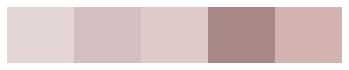

In [13]:
# point RGB값 보여주기

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar


hist = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
temp = np.array([[r1,g1,b1],[r2,g2,b2],[r3,g3,b3],[r4,g4,b4],[r5,g5,b5]])



bar = plot_colors(hist, temp)

plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [14]:
import colorsys

# RGB -> HSV
def revised_rgb_to_hsv(r, g, b):
    (h, s, v) = colorsys.rgb_to_hsv(r/255, g/255, b/255)
    h *= 360
    s *= 100
    v *= 100
    return round(h), round(s), round(v)

h1, s1, v1 = revised_rgb_to_hsv(r1, g1, b1)
h2, s2, v2 = revised_rgb_to_hsv(r2, g2, b2)
h3, s3, v3 = revised_rgb_to_hsv(r3, g3, b3)
h4, s4, v4 = revised_rgb_to_hsv(r4, g4, b4)
h5, s5, v5 = revised_rgb_to_hsv(r5, g5, b5)

In [15]:
import xgboost as xgb
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [16]:
# 데이터로 예측
data = pd.read_excel('data2.xlsx', index_col='순번')

In [18]:
X = data[['H','S', 'V','R', 'G', 'B']]
y = data[['쿨웜']]

X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [19]:
model = xgb.XGBClassifier(silent=False, 
                          booster='gbtree',
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=2000, 
                          max_depth=5, 
                          gamma=10, 
                          seed=777)

In [23]:
model.fit(X_train, y_train)

[13:51:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1,
              random_state=777, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=777, silent=False, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [25]:
point1 = np.array([h1, s1, v1, r1, g1, b1])
point2 = np.array([h2, s2, v2, r2, g2, b2])
point3 = np.array([h3, s3, v3, r3, g3, b3])
point4 = np.array([h4, s4, v4, r4, g4, b4])
point5 = np.array([h5, s5, v5, r5, g5, b5])

points = np.array([point1, point2, point3, point4, point5])

#정규화
points = preprocessing.StandardScaler().fit(points).transform(points)

In [65]:
predict = model.predict(points)
predict_proba = model.predict_proba(points)
print(predict)
print(predict_proba)

[0 0 1 0 1]
[[0.66662306 0.33337694]
 [0.53979635 0.46020362]
 [0.41561663 0.58438337]
 [0.766287   0.23371299]
 [0.3978936  0.6021064 ]]


In [106]:
# 쿨톤
proba_cool = []
for i in range(4):
    if predict_proba[i][0] > 0.5:
        proba_cool.append(predict_proba[i][0])
print(sum(proba_cool)/len(proba_cool)*100)

# 웜톤
proba_warm = []
for i in range(4):
    if predict_proba[i][1] > 0.5:
        proba_warm.append(predict_proba[i][1])
print(sum(proba_warm)/len(proba_warm)*100)

65.75688123703003
58.43833684921265


In [108]:
if predict.sum() >= 3:
    print("웜톤일 확률이 {:.2f}% 입니다.".format(sum(proba_warm)/len(proba_warm)*100))
else:
    print("쿨톤일 확률이 {:.2f}% 입니다.".format(sum(proba_cool)/len(proba_cool)*100))

쿨톤일 확률이 65.76% 입니다.
